Сейчас я тебе предоставлю контекст для решения задачи, а в дальнейшем ты будешь должен ответить на мои вопросы и в итоге совместно со мной написать решение задачи на языке Python.

Мне необходимо разработать алгоритм-индикатор, который прогнозирует краткосрочные ценовые изменения выбранного финансового инструмента. Основная цель — предсказать направление (рост, падение или стабильность) цены на 15-минутный временной интервал с максимально возможной точностью. Модель должна генерировать рекомендации по уровням stop-loss и take-profit для каждой сделки.

Входные данные: В качестве данных используется выгрузка с биржи о движении цен в формате CSV. Данные хранятся в 10 файлах, которые содержат Open High, Low, Close и соответствующий timestamp для 10 различных активов. В каждом файле данные о конкретном активе. Суммарный объем данных составляет около 16 Мб. Данные предоставляются в таймфрейме 15-минут (интервал между данными составляет 15 минут).

Требования к решению (в порядке убывания приоритета):
1. Предсказать направление цены (+1: рост, -1: падение, 0: стабильность на следующий временной интервал.
2. Рассчитать оптимальные уровни stop-loss и take-profit для минимизации риска и максимизации прибыли.
3. Сделки должны идти непрерывно: одна сделка закрылась - следующая открылась.

Решение будет оцениваться в соответствии со следующими метриками (в порядке убывания приоритета):
1. Win-rate – процент прибыльных сделок.
2. PnL (Profit and Loss) – итоговая прибыль/убыток в процентах за определенный период.
3. Количество сделок – количество всех сделок, совершенных в процессе торговли.
4. Максимальная просадка депозита – максимальное снижение капитала за весь период торговли.
5. Средний процент прибыли на сделку – средний процент, полученный за каждую прибыльную сделку.
6. Средняя ширина от точки входа до выхода – средний процент изменения цены от входа в сделку до ее завершения.

Дополнительные условия:
* Ограничений на выбор алгоритмов нет, но крайне приветствуются интерпретируемые модели и модели машинного обучения.
* Stop-loss и take-profit должны быть рассчитаны на основе исторических данных, волатильности, прогнозов модели и других параметров. А ширина от точки входа до stop-loss и take-profit ордеров должна быть фиксирована (risk/reward 1:1). Причем, минимальный диапазон 0.35%, максимальный 2%.

Таким образом, цель задания - разработать алгоритм, который анализирует данные о движении цены криптовалют и автоматически рассчитывает возможные уровни для входа в сделку, стоп-лосса и тейк-профита.

Необязательные, но важные предпочтения:
* Минимальная задержка в обработке данных (реализация модели должна быть пригодна для реального времени).
* Реализация адаптивного расчета stop-loss и take-profit с учетом изменения волатильности в реальном времени
* Нормализация данных (избавление от шумов и аномальных движений).

Если у тебя есть наводящие/уточняюще вопросы, задай их, а также, в любом случае, выскажи свое мнение на счет данного кейса и как бы его решал ты.

В качестве дополнительных фичей, помимо High, Open, Close и Low,  я собираюсь использовать следующие индикаторы: SMA_delta (Дельта скользящих), RSI_14 (Индекс относительной силы), BB_delta_cu, BB_delta_cl, ATR, Mean-reversion, Momentum. Я выбрал стратегию прогнозирования High/Low, а не Close-to-Close. Я хочу обчить LSTM для этих целей. Придумай, учитывая всю специфику задачи, функцию потерь, свой выбор подробно аргументируй.

In [ ]:
Напиши обучающий код, который в том числе будет разбивать исходную выборку на обучающую, валидаационню и тестовую подвыборки.

Вопросы:
1. Какие модели стоит рассмотреть для решения данной задачи? Какие бы ты рекомендовал выбрать и почему? Аргументированно объясни свой ответ.

In [105]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go

import talib as ta

In [106]:
# Вычисление динамического интервала
def calculate_dynamic_range(atr, current_price, min_range=0.0035, max_range=0.02):
    atr_percent = atr / current_price
    dynamic_range = np.clip(atr_percent * 2, min_range, max_range) # Здесь от множетеля зависит итоговое количество сигналов
    return dynamic_range # значение от 0.0035 до 0.02

# Для создания торговых уровней
def calculate_levels(current_price, atr):
    dynamic_range = calculate_dynamic_range(atr, current_price)
    take_profit = current_price * (1 + dynamic_range)
    stop_loss = current_price * (1 - dynamic_range)
    return take_profit, stop_loss

# Для создания таргета
def calculate_target(current_close, next_high, next_low, next_close, dynamic_range):
    upper_breach = (next_high / current_close - 1) >= dynamic_range
    lower_breach = (1 - next_low / current_close) >= dynamic_range
    
    if upper_breach and lower_breach:
        # Выбор по Close следующего бара, если Low ниже, а High выше закрытия предыдущего бара
        if next_close > current_close:
            return 1
        else:
            return -1
    elif upper_breach:
        return 1
    elif lower_breach:
        return -1
    else:
        return 0

In [107]:
df = pd.read_csv(filepath_or_buffer='data/AAVE_USDT_15m_candles.csv', sep=';', index_col=0)
df.index = pd.to_datetime(df.index)

In [278]:
df.head()

,open,high,low,close
timestamp,,,,
2022-12-31 21:00:00,52.7,52.7,52.6,52.6
2022-12-31 21:15:00,52.7,52.7,52.5,52.6
2022-12-31 21:30:00,52.6,52.6,52.4,52.5
2022-12-31 21:45:00,52.5,52.5,52.4,52.4
2022-12-31 22:00:00,52.4,52.5,52.4,52.5


In [108]:
df['next_high'] = df['high'].shift(-1)  # High следующего бара
df['next_low'] = df['low'].shift(-1)    # Low следующего бара
df['next_close'] = df['close'].shift(-1)  # Для обработки конфликта High/Low

# Удаляем последнюю строку с NaN
df = df.dropna(subset=['next_high', 'next_low'])

In [109]:
# Для целевой переменной
df['atr'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
df['dynamic_range'] = df.apply(lambda x: calculate_dynamic_range(x['atr'], x['close']), axis=1) / 2

In [110]:
df['target'] = df.apply(
    lambda row: calculate_target(
        row['close'], row['next_high'], row['next_low'],
        row['next_close'], row['dynamic_range']
    ), axis=1
)

df = df.dropna(subset=['atr', 'dynamic_range'])

In [111]:
df['returns'] = np.log(df['close'] / df['close'].shift(1))

In [283]:
df

,open,high,low,close,next_high,next_low,next_close,atr,dynamic_range,target,returns
timestamp,,,,,,,,,,,
2023-01-01 00:30:00,51.90,52.00,51.80,51.80,51.80,51.70,51.80,0.192857,0.003723,0,NaN
2023-01-01 00:45:00,51.70,51.80,51.70,51.80,51.80,51.70,51.80,0.186224,0.003595,0,0.000000
2023-01-01 01:00:00,51.80,51.80,51.70,51.80,51.80,51.70,51.80,0.180066,0.003476,0,0.000000
2023-01-01 01:15:00,51.70,51.80,51.70,51.80,51.80,51.80,51.80,0.174347,0.003366,0,0.000000
2023-01-01 01:30:00,51.80,51.80,51.80,51.80,51.90,51.70,51.90,0.161893,0.003125,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 22:30:00,112.08,112.52,111.85,112.41,112.48,111.33,112.09,0.797792,0.007097,-1,0.003029
2023-12-30 22:45:00,112.43,112.48,111.33,112.09,112.95,112.02,112.45,0.822949,0.007342,1,-0.002851
2023-12-30 23:00:00,112.08,112.95,112.02,112.45,112.51,112.03,112.15,0.830596,0.007386,0,0.003207


In [112]:
df.target.value_counts()

target
 0    26467
-1     4413
 1     4056
Name: count, dtype: int64

In [113]:
df.reset_index(inplace=True)

In [291]:
# Пример данных
df_viz = df[65:104]

fig = go.Figure(
    data=[
        go.Candlestick(
            x=df_viz["timestamp"],
            open=df_viz["open"],
            high=df_viz["high"],
            low=df_viz["low"],
            close=df_viz["close"],
            name="Candlestick"
        )
    ]
)

# Добавление текстовых меток из колонки target
for _, row in df_viz.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row["timestamp"]],
            y=[row["close"]],  # Метки располагаются на уровне закрытия свечи
            mode="text",
            text=row["target"],
            textposition="top center",
            showlegend=False
        )
    )

# Добавление меток со сдвигом вперёд
for i in range(len(df_viz) - 1):  # Останавливаемся на предпоследней строке
    fig.add_trace(
        go.Scatter(
            x=[df_viz["timestamp"].iloc[i + 1]],  # Метка на следующую свечу
            y=[df_viz["close"].iloc[i] * (1 + df_viz['dynamic_range'].iloc[i])],
            mode="markers+text",
            marker=dict(color="green", size=8),
            text=f"{df_viz['close'].iloc[i] * (1 + df_viz['dynamic_range'].iloc[i]):.2f}",
            textposition="top center",
            showlegend=False
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[df_viz["timestamp"].iloc[i + 1]],  # Метка на следующую свечу
            y=[df_viz["close"].iloc[i] * (1 - df_viz['dynamic_range'].iloc[i])],
            mode="markers+text",
            marker=dict(color="red", size=8),
            text=f"{df_viz['close'].iloc[i] * (1 - df_viz['dynamic_range'].iloc[i]):.2f}",
            textposition="bottom center",
            showlegend=False
        )
    )


# Настройка осей и заголовков
fig.update_layout(
    title="Свечной график",
    xaxis_title="Время",
    yaxis_title="Цена",
    xaxis_rangeslider_visible=False,  # Скрыть ползунок масштаба
    template="plotly_white",
    width=1500,  # Ширина графика
    height=800  # Увеличенная высота
)

# Отображение графика
fig.show()


In [114]:
pd.get_dummies(df["target"], prefix="target")

,target_-1,target_0,target_1
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False
...,...,...,...
34931,True,False,False
34932,False,False,True
34933,False,True,False
34934,False,True,False


In [293]:
# Анализ прибыльности
tp_profit = df[df['target'] == 1]['returns'].mean()
sl_loss = df[df['target'] == -1]['returns'].abs().mean()
print(f"Средний TP: {tp_profit:.4%}, Средний SL: {sl_loss:.4%}")

Средний TP: 0.0082%, Средний SL: 0.3570%


In [296]:
df.drop(['next_high', 'next_low', 'next_close'], inplace=True, axis=1)

### ФУЛ КОД

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import talib as ta


# Вычисление динамического интервала
def calculate_dynamic_range(atr, current_price, min_range=0.0035, max_range=0.02):
    atr_percent = atr / current_price
    dynamic_range = np.clip(atr_percent * 2, min_range, max_range) # Здесь от множетеля зависит итоговое количество сигналов
    return dynamic_range # значение от 0.0035 до 0.02

# Для создания таргета
def calculate_target(current_close, next_high, next_low, next_close, dynamic_range):
    upper_breach = (next_high / current_close - 1) >= dynamic_range
    lower_breach = (1 - next_low / current_close) >= dynamic_range
    
    if upper_breach and lower_breach:
        # Выбор по Close следующего бара, если Low ниже, а High выше закрытия предыдущего бара
        if next_close > current_close:
            return 1
        else:
            return -1
    elif upper_breach:
        return 1
    elif lower_breach:
        return -1
    else:
        return 0
    

df = pd.read_csv(filepath_or_buffer='data/AAVE_USDT_15m_candles.csv', sep=';', index_col=0)
df.index = pd.to_datetime(df.index)

df['next_high'] = df['high'].shift(-1)  # High следующего бара
df['next_low'] = df['low'].shift(-1)    # Low следующего бара
df['next_close'] = df['close'].shift(-1)  # Для обработки конфликта High/Low

# Удаляем последнюю строку с NaN
df = df.dropna(subset=['next_high', 'next_low'])

# Для целевой переменной
df['atr'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
df['dynamic_range'] = df.apply(lambda x: calculate_dynamic_range(x['atr'], x['close']), axis=1) / 2

df['target'] = df.apply(
    lambda row: calculate_target(
        row['close'], row['next_high'], row['next_low'],
        row['next_close'], row['dynamic_range']
    ), axis=1
)

df = df.dropna(subset=['atr', 'dynamic_range'])

df['returns'] = np.log(df['close'] / df['close'].shift(1))

df.reset_index(inplace=True)


# Пример данных
df_viz = df[65:104]

fig = go.Figure(
    data=[
        go.Candlestick(
            x=df_viz["timestamp"],
            open=df_viz["open"],
            high=df_viz["high"],
            low=df_viz["low"],
            close=df_viz["close"],
            name="Candlestick"
        )
    ]
)

# Добавление текстовых меток из колонки target
for _, row in df_viz.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row["timestamp"]],
            y=[row["close"]],  # Метки располагаются на уровне закрытия свечи
            mode="text",
            text=row["target"],
            textposition="top center",
            showlegend=False
        )
    )

# Добавление меток со сдвигом вперёд
for i in range(len(df_viz) - 1):  # Останавливаемся на предпоследней строке
    fig.add_trace(
        go.Scatter(
            x=[df_viz["timestamp"].iloc[i + 1]],  # Метка на следующую свечу
            y=[df_viz["close"].iloc[i] * (1 + df_viz['dynamic_range'].iloc[i])],
            mode="markers+text",
            marker=dict(color="green", size=8),
            text=f"{df_viz['close'].iloc[i] * (1 + df_viz['dynamic_range'].iloc[i]):.2f}",
            textposition="top center",
            showlegend=False
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[df_viz["timestamp"].iloc[i + 1]],  # Метка на следующую свечу
            y=[df_viz["close"].iloc[i] * (1 - df_viz['dynamic_range'].iloc[i])],
            mode="markers+text",
            marker=dict(color="red", size=8),
            text=f"{df_viz['close'].iloc[i] * (1 - df_viz['dynamic_range'].iloc[i]):.2f}",
            textposition="bottom center",
            showlegend=False
        )
    )


# Настройка осей и заголовков
fig.update_layout(
    title="Свечной график",
    xaxis_title="Время",
    yaxis_title="Цена",
    xaxis_rangeslider_visible=False,  # Скрыть ползунок масштаба
    template="plotly_white",
    width=1500,  # Ширина графика
    height=800  # Увеличенная высота
)

# Отображение графика
fig.show()

In [ ]:
# Считаем прибыль/убыток от сделки

df['profit'] = 

tp_sl = ['take_profit', 'stop_loss']

last_pos = 0
curr_tp_sl = tp_sl

for i in range(len(df)):
    if df['target'][i] == 1:
        last_pos = df['target'][i]
        curr_tp_sl = tp_sl
    elif df['target'][i] == -1:
        last_pos = df['target'][i]
        curr_tp_sl = tp_sl[-1]
    else:
        if last_pos:


if df['target'][i - 1] == 1:
    df['close']

1. Profit-Weighted Cross Entropy:

$$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^N w_{y_i} \cdot \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]$$

2. Sharpe Ratio Maximization:

$$\mathcal{L} = -\frac{\text{E}[R]}{\sqrt{\text{Var}[R] + \epsilon}}$$

Как учесть ситуацию, при которой следующая свеча не пересекает SL/TP уровни? В таком случае, по условиям, сделка должна перейти на следующую свечу, но, насколько я понимаю,ты это не учитываешь в предложенном решении. Объясни как реализовать это, а затем перепиши весь текущий код учитывая это.

In [166]:
# Вычисление динамического интервала
def calculate_dynamic_range(atr, current_price, min_range=0.0035, max_range=0.02):
    atr_percent = atr / current_price
    dynamic_range = np.clip(atr_percent, min_range, max_range) # Здесь от множетеля зависит итоговое количество сигналов
    return dynamic_range # значение от 0.0035 до 0.02

def generate_targets(df, max_hold=10):
    targets = []
    for i in range(len(df)):
        entry_price = df.iloc[i]['close']
        dynamic_range = df.iloc[i]['dynamic_range']
        result = 0
        for j in range(1, max_hold+1):
            if i+j >= len(df):
                break
            high = df.iloc[i+j]['high']
            low = df.iloc[i+j]['low']
            close = df.iloc[i+j]['close']

            upper_breach = (high / entry_price - 1) >= dynamic_range / 2
            lower_breach = (1 - low / entry_price) >= dynamic_range / 2

            if upper_breach and lower_breach:
                # Выбор по Close следующего бара, если Low ниже, а High выше закрытия предыдущего бара
                if close > entry_price:
                    result = 1
                    break
                else:
                    result = -1
                    break
            elif upper_breach:
                result = 1
                break
            elif lower_breach:
                result = -1
                break
        targets.append(result)
    return pd.Series(targets, index=df.index)

def prepare_data(df, max_hold=10):
    # Индикаторы
    df['atr'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['returns'] = np.log(df['close'] / df['close'].shift(1))

    df['dynamic_range'] = df.apply(lambda x: calculate_dynamic_range(x['atr'], x['close']), axis=1)
    
    # Генерация целевой переменной
    df['target'] = generate_targets(df, max_hold)
    
    # Фичи
    df['range_pct'] = (df['high'] - df['low']) / df['close']
    df['body_pct'] = (df['close'] - df['open']) / df['open']
    df['sma_10'] = df['close'].rolling(10).mean()
    df['rsi'] = ta.RSI(df['close'], timeperiod=14)
    
    # Удаление NaN
    df = df.dropna(subset=['target', 'atr', 'rsi'])
    
    return df

In [167]:
# Пример использования
df = pd.read_csv('data/AAVE_USDT_15m_candles.csv', sep=';', index_col=0)
df

,open,high,low,close
timestamp,,,,
2022-12-31 21:00:00,52.70,52.70,52.60,52.60
2022-12-31 21:15:00,52.70,52.70,52.50,52.60
2022-12-31 21:30:00,52.60,52.60,52.40,52.50
2022-12-31 21:45:00,52.50,52.50,52.40,52.40
2022-12-31 22:00:00,52.40,52.50,52.40,52.50
...,...,...,...,...
2023-12-30 22:45:00,112.43,112.48,111.33,112.09
2023-12-30 23:00:00,112.08,112.95,112.02,112.45
2023-12-30 23:15:00,112.40,112.51,112.03,112.15


In [168]:
df = df.sort_values('timestamp').reset_index()

In [150]:
df

,timestamp,open,high,low,close
0,2022-12-31 21:00:00,52.70,52.70,52.60,52.60
1,2022-12-31 21:15:00,52.70,52.70,52.50,52.60
2,2022-12-31 21:30:00,52.60,52.60,52.40,52.50
3,2022-12-31 21:45:00,52.50,52.50,52.40,52.40
4,2022-12-31 22:00:00,52.40,52.50,52.40,52.50
...,...,...,...,...,...
34946,2023-12-30 22:45:00,112.43,112.48,111.33,112.09
34947,2023-12-30 23:00:00,112.08,112.95,112.02,112.45
34948,2023-12-30 23:15:00,112.40,112.51,112.03,112.15
34949,2023-12-30 23:30:00,112.10,112.33,111.49,111.50


In [169]:
prepared_df = prepare_data(df, max_hold=10)

In [129]:
prepared_df

,open,high,low,close,atr,returns,dynamic_range,target,range_pct,body_pct,sma_10,rsi
14,51.90,52.00,51.80,51.80,0.192857,-0.001929,0.007446,1,0.003861,-0.001927,51.990,16.666667
15,51.70,51.80,51.70,51.80,0.186224,0.000000,0.007190,1,0.001931,0.001934,51.950,16.666667
16,51.80,51.80,51.70,51.80,0.180066,0.000000,0.006952,1,0.001931,0.000000,51.920,16.666667
17,51.70,51.80,51.70,51.80,0.174347,0.000000,0.006732,1,0.001931,0.001934,51.890,16.666667
18,51.80,51.80,51.80,51.80,0.161893,0.000000,0.006251,1,0.000000,0.000000,51.870,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
34946,112.43,112.48,111.33,112.09,0.822949,-0.002851,0.014684,1,0.010260,-0.003024,112.314,47.081544
34947,112.08,112.95,112.02,112.45,0.830596,0.003207,0.014773,-1,0.008270,0.003301,112.347,51.338584
34948,112.40,112.51,112.03,112.15,0.805553,-0.002671,0.014366,-1,0.004280,-0.002224,112.325,47.881784
34949,112.10,112.33,111.49,111.50,0.808014,-0.005813,0.014494,0,0.007534,-0.005352,112.227,41.380451


In [139]:
prepared_df.target.value_counts()

target
-1    16770
 1    16374
 0     1793
Name: count, dtype: int64

In [140]:
pnl_1 = prepared_df[prepared_df['target'] == 1]['returns'].mean()  # Пример: +0.8%
pnl_neg1 = prepared_df[prepared_df['target'] == -1]['returns'].abs().mean()  # Пример: -1.2%
class_weights = [pnl_neg1, 0.0, pnl_1]  # Веса для [-1, 0, 1]

In [141]:
pnl_1, pnl_neg1, class_weights

(0.9999494947576513,
 1.0001081792491928,
 [1.0001081792491928, 0.0, 0.9999494947576513])

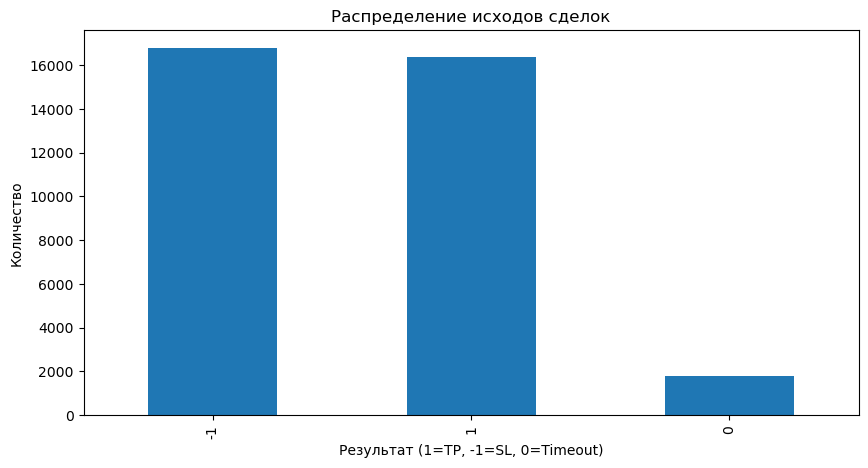

In [142]:
import matplotlib.pyplot as plt

# Распределение результатов
plt.figure(figsize=(10,5))
prepared_df['target'].value_counts().plot(kind='bar')
plt.title('Распределение исходов сделок')
plt.xlabel('Результат (1=TP, -1=SL, 0=Timeout)')
plt.ylabel('Количество')
plt.show()

In [143]:
# Анализ прибыльности
tp_profit = prepared_df[prepared_df['target'] == 1]['returns'].mean()
sl_loss = prepared_df[prepared_df['target'] == -1]['returns'].abs().mean()
print(f"Средний TP: {tp_profit:.4%}, Средний SL: {sl_loss:.4%}")

Средний TP: 99.9949%, Средний SL: 100.0108%


In [146]:
df

,index,open,high,low,close,atr,returns,dynamic_range,target,range_pct,body_pct,sma_10,rsi
0,14,51.90,52.00,51.80,51.80,0.192857,0.998073,0.007446,1,0.003861,-0.001927,51.990,16.666667
1,15,51.70,51.80,51.70,51.80,0.186224,1.000000,0.007190,1,0.001931,0.001934,51.950,16.666667
2,16,51.80,51.80,51.70,51.80,0.180066,1.000000,0.006952,1,0.001931,0.000000,51.920,16.666667
3,17,51.70,51.80,51.70,51.80,0.174347,1.000000,0.006732,1,0.001931,0.001934,51.890,16.666667
4,18,51.80,51.80,51.80,51.80,0.161893,1.000000,0.006251,1,0.000000,0.000000,51.870,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34932,34946,112.43,112.48,111.33,112.09,0.822949,0.997153,0.014684,1,0.010260,-0.003024,112.314,47.081544
34933,34947,112.08,112.95,112.02,112.45,0.830596,1.003212,0.014773,-1,0.008270,0.003301,112.347,51.338584
34934,34948,112.40,112.51,112.03,112.15,0.805553,0.997332,0.014366,-1,0.004280,-0.002224,112.325,47.881784
34935,34949,112.10,112.33,111.49,111.50,0.808014,0.994204,0.014494,0,0.007534,-0.005352,112.227,41.380451


In [174]:
import pandas as pd
import plotly.graph_objects as go

# Пример данных
df = prepared_df[55:85]

fig = go.Figure(
    data=[
        go.Candlestick(
            x=df["timestamp"],
            open=df["open"],
            high=df["high"],
            low=df["low"],
            close=df["close"],
            name="Candlestick"
        )
    ]
)

# Добавление текстовых меток из колонки target
for _, row in df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row["timestamp"]],
            y=[row["close"]],  # Метки располагаются на уровне закрытия свечи
            mode="text",
            text=row["target"],
            textposition="top center",
            showlegend=False
        )
    )

# Добавление меток со сдвигом вперёд
for i in range(len(df) - 1):  # Останавливаемся на предпоследней строке
    fig.add_trace(
        go.Scatter(
            x=[df["timestamp"].iloc[i + 1]],  # Метка на следующую свечу
            y=[df["close"].iloc[i] * (1 + df['dynamic_range'].iloc[i])],
            mode="markers+text",
            marker=dict(color="green", size=8),
            text=f"{df['close'].iloc[i] * (1 + df['dynamic_range'].iloc[i]):.2f}",
            textposition="top center",
            showlegend=False
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[df["timestamp"].iloc[i + 1]],  # Метка на следующую свечу
            y=[df["close"].iloc[i] * (1 - df['dynamic_range'].iloc[i])],
            mode="markers+text",
            marker=dict(color="red", size=8),
            text=f"{df['close'].iloc[i] * (1 - df['dynamic_range'].iloc[i]):.2f}",
            textposition="bottom center",
            showlegend=False
        )
    )


# Настройка осей и заголовков
fig.update_layout(
    title="Свечной график",
    xaxis_title="Время",
    yaxis_title="Цена",
    xaxis_rangeslider_visible=False,  # Скрыть ползунок масштаба
    template="plotly_white"
)

# Отображение графика
fig.show()


In [162]:
df

,timestamp,open,high,low,close,atr,returns,dynamic_range,target,range_pct,body_pct,sma_10,rsi
14,2023-01-01 00:30:00,51.9,52.0,51.8,51.8,0.192857,0.998073,0.007446,1,0.003861,-0.001927,51.99,16.666667
15,2023-01-01 00:45:00,51.7,51.8,51.7,51.8,0.186224,1.000000,0.007190,1,0.001931,0.001934,51.95,16.666667
16,2023-01-01 01:00:00,51.8,51.8,51.7,51.8,0.180066,1.000000,0.006952,1,0.001931,0.000000,51.92,16.666667
17,2023-01-01 01:15:00,51.7,51.8,51.7,51.8,0.174347,1.000000,0.006732,1,0.001931,0.001934,51.89,16.666667
18,2023-01-01 01:30:00,51.8,51.8,51.8,51.8,0.161893,1.000000,0.006251,1,0.000000,0.000000,51.87,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2023-01-02 01:30:00,51.8,51.8,51.6,51.7,0.217876,0.998069,0.008428,1,0.003868,-0.001931,51.87,41.455760
115,2023-01-02 01:45:00,51.7,51.7,51.5,51.6,0.216599,0.998066,0.008395,1,0.003876,-0.001934,51.84,38.616665
116,2023-01-02 02:00:00,51.5,51.7,51.5,51.7,0.215413,1.001938,0.008333,1,0.003868,0.003883,51.81,42.832910
117,2023-01-02 02:15:00,51.7,51.7,51.6,51.6,0.207169,0.998066,0.008030,1,0.001938,-0.001934,51.75,39.882753


### ЧИСТОВИК

In [ ]:
!pip install -U kaleido
!pip install -U tensorflow

In [64]:
import pandas as pd
import numpy as np
import talib as ta

def calculate_dynamic_range(atr: pd.Series, close: pd.Series, 
                           multiplier: float = 2.0,
                           min_range: float = 0.0035, 
                           max_range: float = 0.02) -> pd.Series:
    """Векторизованный расчет динамического диапазона"""
    atr_percent = atr / close
    return np.clip(atr_percent * multiplier, min_range, max_range)

def calculate_targets(df: pd.DataFrame) -> pd.Series:
    """Векторизованный расчет целевой переменной"""
    close = df['close'].values
    next_high = df['next_high'].values
    next_low = df['next_low'].values
    next_close = df['next_close'].values
    dynamic_range = df['dynamic_range'].values
    
    upper_breach = (next_high - close) / close >= dynamic_range
    lower_breach = (close - next_low) / close >= dynamic_range
    close_diff = next_close > close
    
    # Векторизованные условия
    return pd.Series(
        np.select(
            condlist=[
                upper_breach & lower_breach & close_diff,
                upper_breach & lower_breach & ~close_diff,
                upper_breach,
                lower_breach
            ],
            choicelist=[1, -1, 1, -1],
            default=0
        ),
        index=df.index
    )

def prepare_data(filepath: str, multiplier: float = 2.0) -> pd.DataFrame:
    """Оптимизированный пайплайн обработки данных"""
    df = pd.read_csv(filepath, sep=';', index_col=0, parse_dates=True)
    
    # Сдвиги для будущих значений
    for col in ['high', 'low', 'close']:
        df[f'next_{col}'] = df[col].shift(-1)
    
    df = df.dropna(subset=['next_high', 'next_low', 'next_close'])
    
    # Индикаторы
    df['atr'] = ta.ATR(df['high'], df['low'], df['close'], 14)
    df['dynamic_range'] = calculate_dynamic_range(df['atr'], df['close'], multiplier) / 2
    
    # Целевая переменная
    df['target'] = calculate_targets(df)
    
    # Фичи и очистка
    df['returns'] = np.log(df['close'] / df['close'].shift(1))

    return df.dropna(subset=['atr', 'dynamic_range', 'target']).reset_index()


In [65]:
import plotly.graph_objects as go
from typing import Optional

def create_candlestick_chart(
    df: pd.DataFrame, 
    title: str = "Свечной график",
    width: int = 1500,
    height: int = 800
) -> go.Figure:
    """Создание базового свечного графика"""
    fig = go.Figure(
        data=[
            go.Candlestick(
                x=df["timestamp"],
                open=df["open"],
                high=df["high"],
                low=df["low"],
                close=df["close"],
                name="Candlestick"
            )
        ]
    )
    
    fig.update_layout(
        title=title,
        xaxis_title="Время",
        yaxis_title="Цена",
        xaxis_rangeslider_visible=False,
        template="plotly_white",
        width=width,
        height=height
    )
    return fig

def add_target_annotations(fig: go.Figure, df: pd.DataFrame) -> None:
    """Добавление аннотаций целевой переменной"""
    for _, row in df.iterrows():
        fig.add_trace(
            go.Scatter(
                x=[row["timestamp"]],
                y=[row["close"]],
                mode="text",
                text=str(['Stay', 'Buy', 'Sell'][row["target"]]),
                textposition="top center",
                showlegend=False,
                textfont=dict(size=14)
            )
        )

def add_levels(fig: go.Figure, df: pd.DataFrame) -> None:
    """Добавление уровней TP/SL с цветовой индикацией по target"""
    # Фильтруем записи с ненулевым target и получаем следующий таймстемп
    filtered = df[df['target'] != 0].copy()
    filtered['next_timestamp'] = df['timestamp'].shift(-1).loc[filtered.index]

    # Разделяем на две группы
    long_signals = filtered[filtered['target'] == 1]
    short_signals = filtered[filtered['target'] == -1]

    # Уровни для лонгов (target=1)
    if not long_signals.empty:
        # TP (верхний уровень - зеленый)
        fig.add_trace(
            go.Scatter(
                x=long_signals['next_timestamp'],
                y=long_signals['close'] * (1 + long_signals['dynamic_range']),
                mode='markers+text',
                marker=dict(color='green', size=8, symbol='triangle-up'),
                textposition='top center',
                name='Long TP'
            )
        )
        # SL (нижний уровень - красный)
        fig.add_trace(
            go.Scatter(
                x=long_signals['next_timestamp'],
                y=long_signals['close'] * (1 - long_signals['dynamic_range']),
                mode='markers+text',
                marker=dict(color='red', size=8, symbol='triangle-down'),
                textposition='bottom center',
                name='Long SL'
            )
        )

    # Уровни для шортов (target=-1)
    if not short_signals.empty:
        # TP (нижний уровень - зеленый)
        fig.add_trace(
            go.Scatter(
                x=short_signals['next_timestamp'],
                y=short_signals['close'] * (1 - short_signals['dynamic_range']),
                mode='markers+text',
                marker=dict(color='green', size=8, symbol='triangle-down'),
                textposition='bottom center',
                name='Short TP'
            )
        )
        # SL (верхний уровень - красный)
        fig.add_trace(
            go.Scatter(
                x=short_signals['next_timestamp'],
                y=short_signals['close'] * (1 + short_signals['dynamic_range']),
                mode='markers+text',
                marker=dict(color='red', size=8, symbol='triangle-up'),
                textposition='top center',
                name='Short SL'
            )
        )

def calculate_trade_outcome(row: pd.Series) -> dict:
    """Определение параметров сделки и результата"""
    entry_price = row['close']
    tp_level = entry_price * (1 + row['dynamic_range'])
    sl_level = entry_price * (1 - row['dynamic_range'])
    next_high = row['next_high']
    next_low = row['next_low']
    next_close = row['next_close']
    
    # Определение сработавшего уровня
    hit_tp = next_high >= tp_level
    hit_sl = next_low <= sl_level
    
    if row['target'] == 1:
        exit_price = tp_level if hit_tp else sl_level if hit_sl else next_close
        exit_type = 'TP' if hit_tp else 'SL' if hit_sl else 'Close'
    elif row['target'] == -1:
        exit_price = sl_level if hit_sl else tp_level if hit_tp else next_close
        exit_type = 'SL' if hit_sl else 'TP' if hit_tp else 'Close'
    else:
        return None
    
    # Расчет доходности
    pnl = (exit_price / entry_price - 1) * 100
    if row['target'] == -1:
        pnl *= -1
    
    return {
        'entry_time': row['timestamp'],
        'exit_time': row['timestamp'] + pd.Timedelta(minutes=15),
        'entry_price': entry_price,
        'exit_price': exit_price,
        'direction': 'Long' if row['target'] == 1 else 'Short',
        'exit_type': exit_type,
        'pnl': pnl
    }

def add_trade_lines(fig: go.Figure, df: pd.DataFrame) -> None:
    """Добавление линий сделок и аннотаций"""
    trades = df[df['target'] != 0].apply(calculate_trade_outcome, axis=1).dropna()
    
    for trade in trades:
        color = 'green' if trade['pnl'] > 0 else 'red'
        line_width = 1.5
        
        # Линия сделки
        fig.add_trace(
            go.Scatter(
                x=[trade['entry_time'], trade['exit_time']],
                y=[trade['entry_price'], trade['exit_price']],
                mode='lines+markers',
                line=dict(color=color, width=line_width),
                marker=dict(size=6),
                showlegend=False
            )
        )
        
        # Аннотация с доходностью
        fig.add_annotation(
            x=trade['exit_time'],
            y=trade['exit_price'],
            text=f"{trade['pnl']:.2f}%",
            showarrow=False,
            font=dict(color=color, size=12),
            xshift=-20,
            yshift=10 if trade['direction'] == 'Long' else -10
        )
        
        # Маркеры уровней
        fig.add_trace(
            go.Scatter(
                x=[trade['exit_time']],
                y=[trade['exit_price']],
                mode='markers',
                marker=dict(
                    color=color,
                    size=16,
                    symbol='triangle-up' if trade['exit_type'] == 'TP' else 'triangle-down'
                ),
                showlegend=False
            )
        )

In [86]:
def main():
    # Загрузка и подготовка данных
    df = prepare_data('data/AAVE_USDT_15m_candles.csv', multiplier=2)
    tp_profit = df[df['target'] == 1]['returns'].mean()
    sl_loss = df[df['target'] == -1]['returns'].abs().mean()
    print(f"Средний TP: {tp_profit:.4%}, Средний SL: {sl_loss:.4%}")
    print(df.target.value_counts())
    
    # Визуализация
    viz_df = df[65:104]
    fig = create_candlestick_chart(viz_df)
    add_levels(fig, viz_df)
    add_target_annotations(fig, viz_df)
    add_trade_lines(fig, viz_df)  # Заменяем предыдущие аннотации
    
    fig.show()

if __name__ == "__main__":
    main()

Средний TP: 0.0078%, Средний SL: 0.3570%
target
 0    26468
-1     4413
 1     4055
Name: count, dtype: int64


### ОБУЧЕНИЕ

In [87]:
!pip install -U tensorflow

     ---------------------------------------- 0.0/48.6 kB ? eta -:--:--
     ------------------------- -------------- 30.7/48.6 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 48.6/48.6 kB 833.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/390.2 MB 1.1 MB/s eta 0:05:59
   ---------------------------------------- 0.1/390.2 MB 845.5 kB/s eta 0:07:42
   ---------------------------------------- 0.1/390.2 MB 944.1 kB/s eta 0:06:54
   ---------------------------------------- 0.2/390.2 MB 926.0 kB/s eta 0:07:02
   ---------------------------------------- 0.2/390.2 MB 901.1 kB/s eta 0:07:13
   ---------------------------------------- 0.3/390.2 MB 983.9 kB/s eta 0:06:37
   ---------------------------------------- 0.3/390.2 MB 893.0 kB/s eta 0:07:17
   ---------------------------------------- 0.4/390.2 MB 955.7 kB/s 

In [91]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

In [93]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Динамический график изменения learning rate с "прогревом" (warm-up)."""

    def init(self, initial_lr=1e-4, warmup_steps=1000):
        super().init()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
    

    def __call__(self, step):
        return tf.minimum(
            self.initial_lr * (step / self.warmup_steps)**0.5,
            self.initial_lr
        )
    
def weighted_asymmetric_loss(y_true, y_pred):
    """
    Асимметричная взвешенная кросс-энтропия для задачи классификации направления.
    Ожидается, что y_true содержит one-hot вектора (shape [batch, 3]), а y_pred — вероятности (softmax).
    """
    # Определяем индексы истинного класса
    true_idx = tf.argmax(y_true, axis=1)
    
    # Присваиваем веса: 1.5 для класса "Падение" (index=2),
    # 0.7 для "Стабильность" (index=1), 1.0 для "Рост" (index=0)
    weights = tf.where(true_idx == 2,           # Класс "Падение" 1.5,
                       tf.where(true_idx == 1, # Класс "Стабильность" 0.7, 1.0 # Класс "Рост" 
                        )
    )
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    return tf.reduce_mean(ce * weights)
    

def mare_loss(y_true, y_pred):
    """
    MARE (Mean Absolute Relative Error). Подходит для процентных изменений.
    """
    return tf.reduce_mean( tf.abs((y_true - y_pred) / (y_true + 1e-8)) )

def temporal_consistency_loss(y_pred):
    """
    Пример регуляризации временной согласованности (демонстрация).
    Для реальных временных рядов чаще обрабатывают последовательные выходы.
    """
    # В данном упрощённом примере возвращаем 0, чтобы не вносить вклад в итоговую функцию потерь.
    return 0.0


class CustomLoss(tf.keras.losses.Loss):
    """
    Комбинированная функция потерь, объединяющая:
    - weighted_asymmetric_loss для направления
    - mare_loss для уровней High/Low
    - опционально temporal_consistency_loss
    """
    
    def init(self, alpha=0.3, beta=0.2, name='custom_loss'):
        super().init(name=name)
        self.alpha = alpha # Вес модельного вклада для прогноза High/Low
        self.beta = beta # Вес временной регуляризации (демонстрация)
    
    def call(self, y_true, y_pred):
        # y_pred — список [direction_pred, high_pred, low_pred]
        direction_pred = y_pred[0]
        high_pred = y_pred[1]
        low_pred = y_pred[2]

        # y_true — список [direction_true, high_true, low_true]
        direction_true = y_true[0]
        high_true = y_true[1]
        low_true = y_true[2]

        # Основные компоненты потерь
        ce_loss = weighted_asymmetric_loss(direction_true, direction_pred)
        hl_loss = 0.5 * (mare_loss(high_true, high_pred) + mare_loss(low_true, low_pred))
        temp_loss = self.beta * temporal_consistency_loss(direction_pred)  # Пример

        total_loss = ce_loss + self.alpha * hl_loss + temp_loss
        return total_loss

In [94]:
def create_lstm_model(input_shape, n_units=64, freeze_encoder=False):
    """
    Cоздание мультивыходной LSTM-модели: - 1 выход для трехклассовой
    классификации направления (direction) - 2 выхода для регрессии High/Low.
    """

    inputs = Input(shape=input_shape, name='input_layer')

    # Предположим, что последний столбец в фичах — это ATR (пример).
    atr = Lambda(lambda x: x[:, :, -1:], name='atr_slice')(inputs)

    x = LSTM(n_units, return_sequences=True, name='lstm1')(inputs)
    x = LSTM(n_units // 2, return_sequences=False, name='lstm2')(x)

    # Направление (3 класса)
    direction_branch = Dense(32, activation='selu', name='direction_dense')(x)
    direction_out = Dense(3, activation='softmax', name='direction')(direction_branch)

    # Прогноз High/Low
    # Для примера, просто склеим выход LSTM со значением ATR ( squeeze )
    hl_concat = concatenate([x, tf.squeeze(atr, axis=[1, 2])], name='concat_atr')
    hl_hidden = Dense(32, activation='selu', name='hl_dense')(hl_concat)
    high_out = Dense(1, activation='linear', name='high')(hl_hidden)
    low_out = Dense(1, activation='linear', name='low')(hl_hidden)

    model = Model(inputs=inputs, outputs=[direction_out, high_out, low_out])

    # Если freeze_encoder == True, "замораживаем" все слои энкодера, кроме последних
    if freeze_encoder:
        # -6, чтобы оставить trainable: direction_dense, direction, concat_atr, hl_dense, high, low
        # а также упомянутый LSTM2 (если хочется). Можно отрегулировать под задачу.
        for layer in model.layers[:-6]:
            layer.trainable = False

    return model

In [104]:
dummy_data

,timestamp,open,high,low,close
0,2022-12-31 21:00:00,52.70,52.70,52.60,52.60
1,2022-12-31 21:15:00,52.70,52.70,52.50,52.60
2,2022-12-31 21:30:00,52.60,52.60,52.40,52.50
3,2022-12-31 21:45:00,52.50,52.50,52.40,52.40
4,2022-12-31 22:00:00,52.40,52.50,52.40,52.50
...,...,...,...,...,...
34946,2023-12-30 22:45:00,112.43,112.48,111.33,112.09
34947,2023-12-30 23:00:00,112.08,112.95,112.02,112.45
34948,2023-12-30 23:15:00,112.40,112.51,112.03,112.15
34949,2023-12-30 23:30:00,112.10,112.33,111.49,111.50


In [95]:
def prepare_data(data, window_size=30):
    """
    Подготовка данных: Превращаем [samples, features] ->
    [samples, window_size, features] для LSTM. Предполагается, что в data:
    - первые три столбца для one-hot направления,
    - четвертый столбец — High,
    - пятый столбец — Low,
    - остальные — вспомогательные фичи (open, close, atr и т.д.).
    """
    
    X, y_dir, y_high, y_low = [], [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size : i]) # direction (one-hot) в колонках 0..2
        y_dir.append(data[i, 0:3]) # High — column 3, Low — column 4
        y_high.append(data[i, 3])
        y_low.append(data[i, 4])
        X = np.array(X)
        y_dir = np.array(y_dir)
        y_high = np.array(y_high).reshape(-1, 1)
        y_low = np.array(y_low).reshape(-1, 1)
        return X, [y_dir, y_high, y_low]


In [115]:
from feature_engineering import AAVE
AAVE

,timestamp,open,high,low,close,SMA_delta,RSI_14,BB_delta_cu,BB_delta_cl,ATR,Revers,Moment
0,2022-12-31 21:00:00,52.70,52.70,52.60,52.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-31 21:15:00,52.70,52.70,52.50,52.60,NaN,NaN,NaN,NaN,NaN,-0.001899,-0.001899
2,2022-12-31 21:30:00,52.60,52.60,52.40,52.50,NaN,NaN,NaN,NaN,NaN,-0.000000,-0.001899
3,2022-12-31 21:45:00,52.50,52.50,52.40,52.40,NaN,NaN,NaN,NaN,NaN,-0.000000,-0.001903
4,2022-12-31 22:00:00,52.40,52.50,52.40,52.50,NaN,NaN,NaN,NaN,NaN,-0.000000,-0.001907
...,...,...,...,...,...,...,...,...,...,...,...,...
34946,2023-12-30 22:45:00,112.43,112.48,111.33,112.09,1.00110,44.783715,0.830014,0.531014,0.713212,-0.000178,0.002940
34947,2023-12-30 23:00:00,112.08,112.95,112.02,112.45,0.92620,52.736318,0.450825,0.786825,0.834117,0.000089,-0.003029
34948,2023-12-30 23:15:00,112.40,112.51,112.03,112.15,0.85815,53.132832,0.676968,0.348968,0.788235,0.000445,0.003296
34949,2023-12-30 23:30:00,112.10,112.33,111.49,111.50,0.83045,39.568345,1.364445,-0.246555,0.753804,0.000446,-0.002227


In [96]:
def scale_data(dummy_data):
    scaler = RobustScaler()
    return scaler.fit_transform(dummy_data)

In [102]:
def main():
    num_features = 4

    dummy_data = pd.read_csv('data/AAVE_USDT_15m_candles.csv', sep=';') # Загрузка (или генерация) данны
    dummy_data.drop('timestamp', axis=1, inplace=True)

    scaled_data = scale_data(dummy_data) # Масштабирование данных

    #-------------------------------------------------------------------------
    # 3. Подготовка временных окон
    #-------------------------------------------------------------------------
    window_size = 30
    X_seq, y_seq = prepare_data(scaled_data, window_size=window_size)

    # Разделяем на train/val/test (70% / 15% / 15%)
    total_samples = X_seq.shape[0]
    train_end = int(0.7 * total_samples)
    val_end = int(0.85 * total_samples)

    X_train = X_seq[:train_end]
    X_val   = X_seq[train_end:val_end]
    X_test  = X_seq[val_end:]

    y_dir_train, y_high_train, y_low_train = y_seq[0][:train_end], y_seq[1][:train_end], y_seq[2][:train_end]
    y_dir_val,   y_high_val,   y_low_val   = y_seq[0][train_end:val_end], y_seq[1][train_end:val_end], y_seq[2][train_end:val_end]
    y_dir_test,  y_high_test,  y_low_test  = y_seq[0][val_end:], y_seq[1][val_end:], y_seq[2][val_end:]

    #-------------------------------------------------------------------------
    # 4. Создание и первый этап обучения модели
    #-------------------------------------------------------------------------
    print("Stage 1: Initial Training")

    model = create_lstm_model(
        input_shape=(window_size, num_features),
        n_units=64,
        freeze_encoder=False
    )

    # Используем динамический learning rate
    lr_schedule = CustomSchedule(initial_lr=1e-3)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss={
            'direction': weighted_asymmetric_loss,  # для направления
            'high': mare_loss,                      # для High
            'low': mare_loss                        # для Low
        },
        loss_weights=[0.7, 0.15, 0.15],  # относительные веса лоссов
        metrics={
            'direction': 'accuracy',
            'high': 'mae',
            'low': 'mae'
        }
    )

    train_targets = {
        'direction': y_dir_train,
        'high': y_high_train,
        'low': y_low_train
    }
    val_targets = {
        'direction': y_dir_val,
        'high': y_high_val,
        'low': y_low_val
    }

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        EarlyStopping(monitor='val_direction_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
    ]

    history_stage1 = model.fit(
        X_train,
        train_targets,
        epochs=25,
        batch_size=64,
        validation_data=(X_val, val_targets),
        callbacks=callbacks,
        verbose=1
    )

    #-------------------------------------------------------------------------
    # 5. Второй этап обучения (fine-tuning) с заморозкой энкодера
    #-------------------------------------------------------------------------
    print("\nStage 2: Fine-Tuning with Frozen Encoder")

    model_fine_tune = create_lstm_model(
        input_shape=(window_size, num_features),
        n_units=64,
        freeze_encoder=True
    )
    # Переносим веса с первого этапа
    model_fine_tune.set_weights(model.get_weights())

    # Компилируем уже с комбинированной CustomLoss
    model_fine_tune.compile(
        optimizer=Adam(1e-5),
        loss=CustomLoss(alpha=0.3, beta=0.2),
        metrics={
            'direction': 'accuracy',
            'high': 'mae',
            'low': 'mae'
        }
    )

    # Здесь цели нужно в виде списка [dir, high, low]:
    history_stage2 = model_fine_tune.fit(
        X_train,
        [y_dir_train, y_high_train, y_low_train],
        epochs=15,
        batch_size=64,
        validation_data=(X_val, [y_dir_val, y_high_val, y_low_val]),
        verbose=1
    )

    #-------------------------------------------------------------------------
    # 6. Оценка на тестовой выборке
    #-------------------------------------------------------------------------
    print("\nModel Evaluation on Test Set:")
    test_results = model_fine_tune.evaluate(
        X_test,
        [y_dir_test, y_high_test, y_low_test],
        verbose=1
    )
    # test_results = [total_loss, direction_loss, high_loss, low_loss,
    #                 direction_accuracy, high_mae, low_mae] (зависит от порядка outputs и metrics)
    print("Test Results:", test_results)

    #-------------------------------------------------------------------------
    # 7. Визуализация истории обучения
    #-------------------------------------------------------------------------
    plt.figure(figsize=(12, 4))

    # История Stage 1: график loss и accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_stage1.history['loss'], label='Train Loss (Stage 1)')
    plt.plot(history_stage1.history['val_loss'], label='Val Loss (Stage 1)')
    plt.title('Stage 1: Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    if 'direction_accuracy' in history_stage1.history:
        plt.plot(history_stage1.history['direction_accuracy'], label='Train Acc (Stage 1)')
    if 'val_direction_accuracy' in history_stage1.history:
        plt.plot(history_stage1.history['val_direction_accuracy'], label='Val Acc (Stage 1)')
    plt.title('Stage 1: Direction Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # История Stage 2: график loss и accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_stage2.history['loss'], label='Train Loss (Stage 2)')
    plt.plot(history_stage2.history['val_loss'], label='Val Loss (Stage 2)')
    plt.title('Stage 2: Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    if 'direction_accuracy' in history_stage2.history:
        plt.plot(history_stage2.history['direction_accuracy'], label='Train Acc (Stage 2)')
    if 'val_direction_accuracy' in history_stage2.history:
        plt.plot(history_stage2.history['val_direction_accuracy'], label='Val Acc (Stage 2)')
    plt.title('Stage 2: Direction Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    #-------------------------------------------------------------------------
    # 8. Сохранение итоговой модели (пример)
    #-------------------------------------------------------------------------
    model_fine_tune.save('trading_model_v1.h5')
    print("\nFine-tuned model saved: trading_model_v1.h5")

if __name__ == "__main__":
    main()

IndexError: index 4 is out of bounds for axis 1 with size 4

---------------

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import RobustScaler

def create_lstm_model(input_shape, n_units=64, freeze_encoder=False):
    """Создает multi-output LSTM архитектуру"""
    inputs = Input(shape=input_shape)
    
    # Интеграция ATR как дополнительного канала
    atr = Lambda(lambda x: x[:,:,-1:])(inputs)  # Предполагаем, что ATR последний фича
    
    # Основная LSTM ветка
    lstm1 = LSTM(n_units, return_sequences=True)(inputs)
    lstm2 = LSTM(n_units//2, return_sequences=False)(lstm1)
    
    # Ветка для прогноза направления
    direction_branch = Dense(32, activation='selu')(lstm2)
    direction_out = Dense(3, activation='softmax', name='direction')(direction_branch)
    
    # Ветка для прогноза High/Low с учетом ATR
    hl_branch = concatenate([lstm2, atr[:, -1, :]])
    hl_branch = Dense(32, activation='selu')(hl_branch)
    high_out = Dense(1, activation='linear', name='high')(hl_branch)
    low_out = Dense(1, activation='linear', name='low')(hl_branch)

    model = Model(
        inputs=inputs, 
        outputs=[direction_out, high_out, low_out]
    )
    
    if freeze_encoder:
        for layer in model.layers[:-6]:  # Замораживаем encoder
            layer.trainable = False
            
    return model

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Динамический learning rate с warmup"""
    def __init__(self, initial_lr=1e-4, warmup_steps=1000):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return tf.minimum(
            self.initial_lr * (step / self.warmup_steps)**0.5,
            self.initial_lr
        )

def weighted_asymmetric_loss(y_true, y_pred):
    """Асимметричная взвешенная кросс-энтропия"""
    weights = tf.where(
        tf.argmax(y_true, axis=1) == 2,  # Класс падения
        1.5,  # Вес для false negative
        tf.where(
            tf.argmax(y_true, axis=1) == 1,  # Стабильность
            0.7,
            1.0  # Вес для роста
        )
    )
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(ce * weights)

def mare_loss(y_true, y_pred):
    """Mean Absolute Relative Error с защитой от деления на ноль"""
    return tf.reduce_mean(
        tf.abs((y_true - y_pred) / (y_true + 1e-8))
    )

def temporal_consistency_loss(y_pred):
    """Регуляризация временной согласованности"""
    return tf.reduce_mean(
        tf.abs(y_pred[:, 1:] - y_pred[:, :-1])
    )

class CustomLoss(tf.keras.losses.Loss):
    """Комбинированная функция потерь"""
    def __init__(self, alpha=0.3, beta=0.2, name='custom_loss'):
        super().__init__(name=name)
        self.alpha = alpha  # Вес для HL loss
        self.beta = beta    # Вес для temporal loss

    def call(self, y_true, y_pred):
        # Разделяем выходы модели
        direction_pred = y_pred[0]
        high_pred = y_pred[1]
        low_pred = y_pred[2]
        
        # Разделяем истинные значения
        direction_true = y_true[0]
        high_true = y_true[1]
        low_true = y_true[2]
        
        # Компоненты потерь
        ce_loss = weighted_asymmetric_loss(direction_true, direction_pred)
        hl_loss = 0.5*(mare_loss(high_true, high_pred) + mare_loss(low_true, low_pred))
        temp_loss = self.beta * temporal_consistency_loss(direction_pred)
        
        return ce_loss + self.alpha*hl_loss + temp_loss

def prepare_data(data, window_size=30):
    """Подготовка временных окон для LSTM"""
    X, y_dir, y_high, y_low = [], [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y_dir.append(data[i, 0])   # Направление
        y_high.append(data[i, 1])  # High
        y_low.append(data[i, 2])   # Low
    return np.array(X), [np.array(y_dir), np.array(y_high), np.array(y_low)]

# Пример использования
if __name__ == "__main__":
    # 1. Загрузка и предобработка данных
    # Предполагаем, что data уже загружен и содержит [direction, high, low, features...]
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    
    # 2. Создание временных окон
    X, y = prepare_data(scaled_data, window_size=30)
    
    # 3. Разделение на train/val
    split = int(0.8 * len(X))
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = [y[0][:split], y[1][:split], y[2][:split]], \
                     [y[0][split:], y[1][split:], y[2][split:]]

    # 4. Инициализация модели
    model = create_lstm_model(input_shape=(30, X.shape[2]))
    
    # 5. Компиляция с кастомным learning rate
    lr_schedule = CustomSchedule(initial_lr=1e-3)
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(
        optimizer=optimizer,
        loss={
            'direction': weighted_asymmetric_loss,
            'high': mare_loss,
            'low': mare_loss
        },
        loss_weights=[0.7, 0.15, 0.15],  # Веса для каждого выхода
        metrics={
            'direction': 'accuracy',
            'high': 'mae',
            'low': 'mae'
        }
    )

    # 6. Коллбеки
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        EarlyStopping(monitor='val_direction_accuracy', patience=15, mode='max')
    ]

    # 7. Первый этап обучения
    print("Stage 1: Initial Training")
    stage1_history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    # 8. Второй этап с заморозкой encoder
    print("\nStage 2: Fine-tuning")
    model = create_lstm_model(
        input_shape=(30, X.shape[2]), 
        freeze_encoder=True
    )
    
    # Переносим веса из первой модели
    model.set_weights(model.get_weights()) 
    
    model.compile(
        optimizer=Adam(1e-5),
        loss=CustomLoss(alpha=0.3, beta=0.2),
        metrics={
            'direction': 'accuracy',
            'high': 'mae',
            'low': 'mae'
        }
    )

    stage2_history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_val, y_val)
    )

    # 9. Сохранение модели
    model.save('trading_model_v1.h5')
